In [52]:
#importing packages
import pandas as pd
import numpy as np

In [53]:
# Importing the dataset
X = pd.read_csv('../Datasets/NB.csv')
X['Fault'] = 0

y = pd.read_csv('../Datasets/IR - 7.csv')
y['Fault'] = 1

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 0)

y_train, y_test = train_test_split(y, test_size = 0.2, random_state = 0)

In [55]:
train = pd.concat([X_train, y_train], ignore_index=True)
train

,DE,FE,Fault
0,0.062585,0.041091,0
1,-0.075102,-0.013765,0
2,-0.048190,-0.001233,0
3,0.069260,0.028558,0
4,0.040054,0.065335,0
...,...,...,...
193843,0.110131,-0.312085,1
193844,-0.909962,-0.030202,1
193845,0.676380,0.007396,1
193846,0.011208,0.209975,1


In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train))
# Random shuffle training data
train.sample(frac=1)

test = pd.DataFrame(scaler.transform(test))

W:\dev\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')

train_PCA = pca.fit_transform(train)
train_PCA = pd.DataFrame(train_PCA)
train_PCA.index = train.index

test_PCA = pca.transform(test)
test_PCA = pd.DataFrame(test_PCA)
test_PCA.index = test.index

In [58]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [59]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [60]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [61]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [62]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [63]:
data_train = np.array(train_PCA.values)
data_test = np.array(test_PCA.values)

In [64]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [65]:
mean_distr = data_train.mean(axis=0)

In [66]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

C:\Users\inkyd\AppData\Local\Temp\ipykernel_39776\2334384244.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.square(dist_train),


(0.0, 15.0)

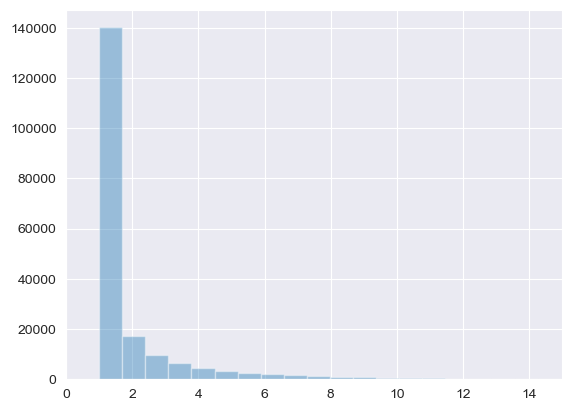

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.distplot(np.square(dist_train),
             bins = 50, 
             kde= False);
plt.xlim([0.0,15])

C:\Users\inkyd\AppData\Local\Temp\ipykernel_39776\377184411.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dist_train,


Text(0.5, 0, 'Mahalanobis dist')

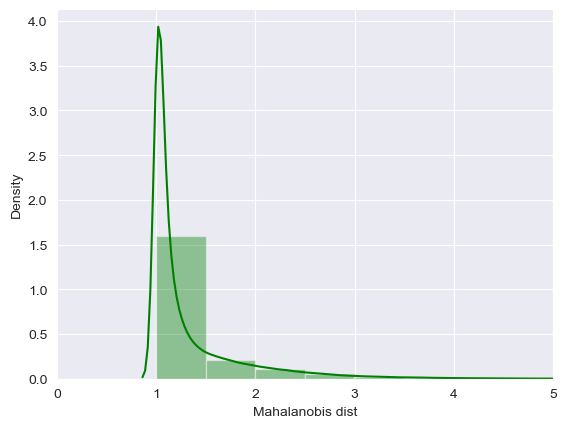

In [68]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [69]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob_dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob_dist'] > anomaly_train['Thresh']
anomaly_train.index = train_PCA.index

In [70]:
anomalies = anomaly_train[anomaly_train['Anomaly'] == True]
print(anomalies)
print(anomalies.shape)

        Mob_dist    Thresh  Anomaly
96957   5.215875  3.944094     True
97034   3.991707  3.944094     True
97047   4.279628  3.944094     True
97141   3.964335  3.944094     True
97193   4.381062  3.944094     True
...          ...       ...      ...
192982  4.845895  3.944094     True
193077  5.327633  3.944094     True
193311  4.164236  3.944094     True
193550  3.957741  3.944094     True
193674  3.944423  3.944094     True

[831 rows x 3 columns]
(831, 3)


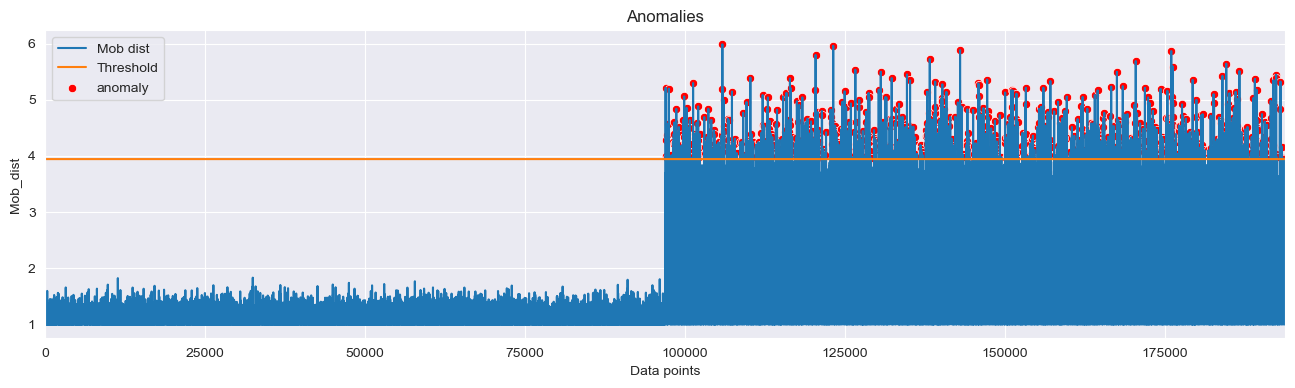

In [71]:
f, (ax1) = plt.subplots(figsize=(16, 4))
ax1.plot(anomaly_train.index, anomaly_train.Mob_dist, label='Mob dist');
ax1.plot(anomaly_train.index, anomaly_train.Thresh, label='Threshold')
g = sns.scatterplot(x=anomalies.index , y=anomalies.Mob_dist, label='anomaly', color='red')
g.set(xlim = (0, len(anomaly_train.index)))
plt.title('Anomalies')
plt.xlabel('Data points')
plt.legend();

In [72]:
anomaly_test = pd.DataFrame()
anomaly_test['Mob_dist']= dist_test
anomaly_test['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_test['Anomaly'] = anomaly_test['Mob_dist'] > anomaly_test['Thresh']
anomaly_test.index = test_PCA.index
anomaly_test.head()

,Mob_dist,Thresh,Anomaly
0,3.195945,3.944094,False
1,3.205233,3.944094,False
2,3.377189,3.944094,False
3,3.203383,3.944094,False
4,3.131419,3.944094,False


In [73]:
IR_anomalies = anomaly_test[anomaly_test['Anomaly'] == True]
print(IR_anomalies)
print(IR_anomalies.shape)

       Mob_dist    Thresh  Anomaly
24232  4.015588  3.944094     True
24236  4.070257  3.944094     True
24238  3.977241  3.944094     True
24240  4.451963  3.944094     True
24264  4.867121  3.944094     True
...         ...       ...      ...
48420  4.071427  3.944094     True
48423  4.317577  3.944094     True
48430  4.162159  3.944094     True
48431  4.160624  3.944094     True
48447  4.126034  3.944094     True

[2852 rows x 3 columns]
(2852, 3)


In [74]:
print("Anomalies: {}".format(IR_anomalies['Anomaly'].count()))

Anomalies: 2852
